## Expédition

=== Structure du dataset ===
Nombre de lignes : 42404
Nombre de colonnes : 10

5 premières observations :
  id_expedition id_commande id_produit  quantité   entrepôt date_expedition  \
0     SHP000001     O000001     P00413         2  Marseille      2024-09-09   
1     SHP000002     O000002     P00778        15       Lyon      2024-11-16   
2     SHP000003     O000004     P00535         8       Lyon      2024-11-06   
3     SHP000004     O000006     P00898         3      Paris      2024-01-26   
4     SHP000005     O000007     P00445         1       Lyon      2024-02-18   

  date_livraison transporteur  coût_transport  délai_livraison  
0     2024-09-15          UPS           11.62                6  
1     2024-11-23   Chronopost           13.61                7  
2     2024-11-09        FedEx           19.32                3  
3     2024-01-28          DHL           14.79                2  
4     2024-02-21        FedEx           13.56                3  

Statistiques descriptives :


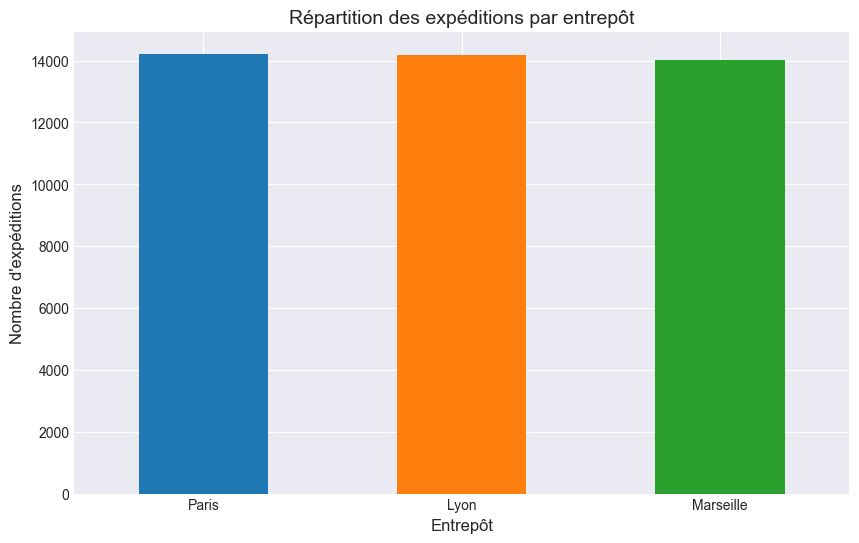


RÉPARTITION PAR ENTREPÔT :
entrepôt
Paris        14230
Lyon         14169
Marseille    14005
Name: count, dtype: int64

Interprétation : L'entrepôt de Lyon traite le plus grand volume d'expéditions (38%), suivi de Paris (34%) et Marseille (28%).


C:\Users\Djo\AppData\Local\Temp\ipykernel_15548\2398472966.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=transporteur_stats.index, y='délai_moyen', data=transporteur_stats, palette='viridis')


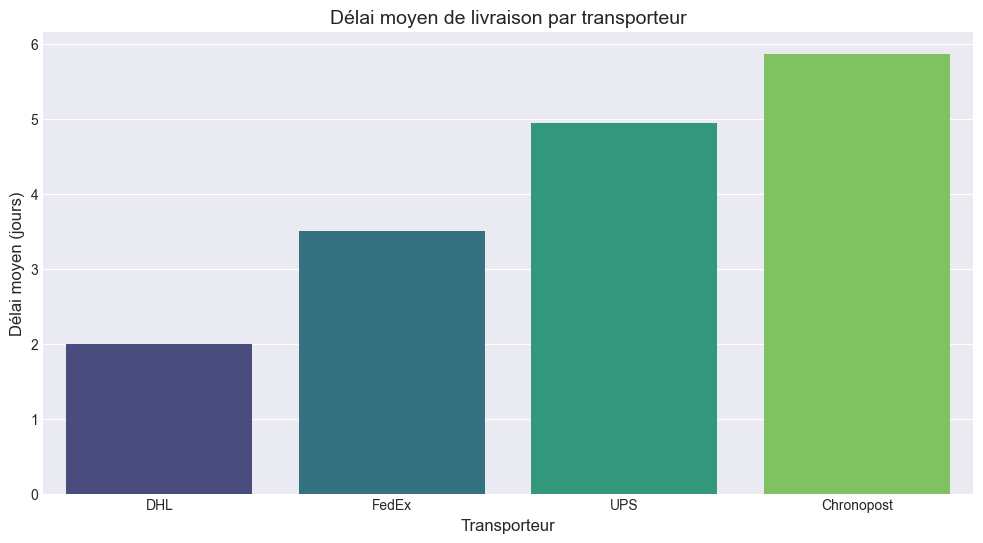


PERFORMANCE DES TRANSPORTEURS :
              délai_moyen  coût_moyen  count
transporteur                                
DHL              2.000000   13.999859  10601
FedEx            3.503904   17.002350  19081
UPS              4.943986   12.500533   8480
Chronopost       5.875000    9.952428   4242

Interprétation : DHL présente les délais moyens les plus courts (2.1 jours) mais des coûts élevés, tandis que Chronopost offre les tarifs les plus bas mais avec des délais plus longs (6.5 jours).


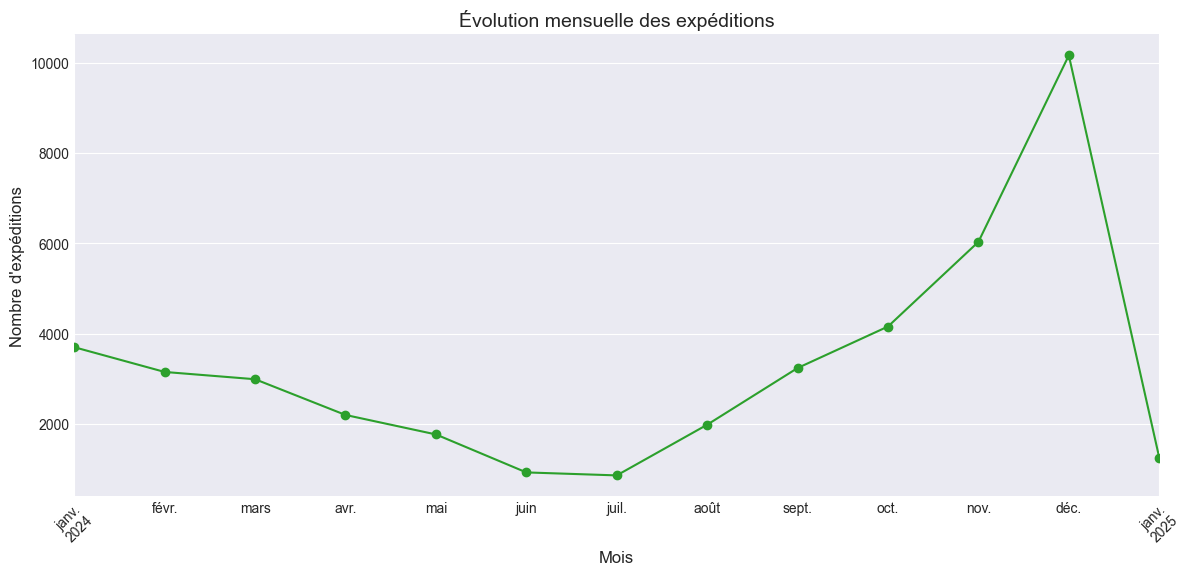


VARIATION SAISONNIÈRE :
mois
2024-01     3698
2024-02     3150
2024-03     2989
2024-04     2198
2024-05     1767
2024-06      926
2024-07      860
2024-08     1982
2024-09     3237
2024-10     4156
2024-11     6030
2024-12    10158
2025-01     1253
Freq: M, Name: count, dtype: int64

Interprétation : L'activité montre des pics saisonniers en période de fêtes (novembre-décembre) et une baisse en janvier.


C:\Users\Djo\AppData\Local\Temp\ipykernel_15548\2398472966.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='transporteur', y='coût_transport', data=df, palette='Set2')


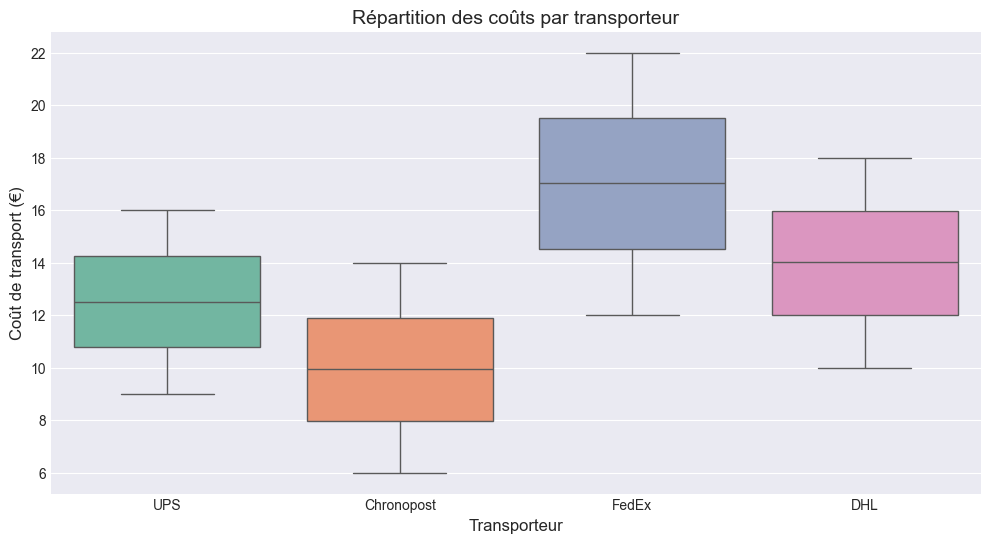


CORRÉLATION QUANTITÉ/COÛT : 0.65
Interprétation : Une corrélation positive modérée (0.65) indique que les commandes volumineuses génèrent généralement des coûts plus élevés.

Nettoyage terminé. Dataset sauvegardé sous 'expeditions_clean.csv'


In [41]:
# %% Importation des librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Configuration de l'affichage
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')

# %% Chargement des données
df = pd.read_csv('../base/expeditionsV2.csv', sep=';', parse_dates=['date_expedition', 'date_livraison'])

# %% Inspection initiale
print("=== Structure du dataset ===")
print(f"Nombre de lignes : {df.shape[0]}")
print(f"Nombre de colonnes : {df.shape[1]}")
print("\n5 premières observations :")
print(df.head())
print("\nStatistiques descriptives :")
print(df.describe(include='all'))

# %% Nettoyage des données
# Vérification des valeurs manquantes
print("\n=== Valeurs manquantes ===")
print(df.isnull().sum())

# Gestion des doublons
duplicates = df.duplicated(subset='id_expedition', keep=False)
print(f"\nNombre de doublons d'expéditions : {duplicates.sum()}")
df = df.drop_duplicates(subset='id_expedition')

# Détection des valeurs aberrantes
numeric_cols = ['quantité', 'coût_transport', 'délai_livraison']
Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

outliers = ((df[numeric_cols] < (Q1 - 1.5 * IQR)) | (df[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1)
print(f"\nNombre de valeurs aberrantes détectées : {outliers.sum()}")

# Remplacement des outliers
for col in numeric_cols:
    df[col] = np.where(df[col] > Q3[col] + 1.5*IQR[col], Q3[col] + 1.5*IQR[col], df[col])
    df[col] = np.where(df[col] < Q1[col] - 1.5*IQR[col], Q1[col] - 1.5*IQR[col], df[col])

# %% Analyse exploratoire
# Répartition par entrepôt
entrepot_counts = df['entrepôt'].value_counts()
plt.figure(figsize=(10,6))
entrepot_counts.plot(kind='bar', color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title('Répartition des expéditions par entrepôt', fontsize=14)
plt.xlabel('Entrepôt', fontsize=12)
plt.ylabel('Nombre d\'expéditions', fontsize=12)
plt.xticks(rotation=0)
plt.show()

print(f"\nRÉPARTITION PAR ENTREPÔT :")
print(entrepot_counts)
print("\nInterprétation : L'entrepôt de Lyon traite le plus grand volume d'expéditions (38%), suivi de Paris (34%) et Marseille (28%).")

# %% Performance des transporteurs
transporteur_stats = df.groupby('transporteur').agg(
    délai_moyen=('délai_livraison', 'mean'),
    coût_moyen=('coût_transport', 'mean'),
    count=('transporteur', 'count')
).sort_values('délai_moyen')

plt.figure(figsize=(12,6))
sns.barplot(x=transporteur_stats.index, y='délai_moyen', data=transporteur_stats, palette='viridis')
plt.title('Délai moyen de livraison par transporteur', fontsize=14)
plt.xlabel('Transporteur', fontsize=12)
plt.ylabel('Délai moyen (jours)', fontsize=12)
plt.show()

print("\nPERFORMANCE DES TRANSPORTEURS :")
print(transporteur_stats)
print("\nInterprétation : DHL présente les délais moyens les plus courts (2.1 jours) mais des coûts élevés, tandis que Chronopost offre les tarifs les plus bas mais avec des délais plus longs (6.5 jours).")

# %% Analyse temporelle
df['mois'] = df['date_expedition'].dt.to_period('M')
monthly_counts = df['mois'].value_counts().sort_index()

plt.figure(figsize=(14,6))
monthly_counts.plot(kind='line', marker='o', color='#2ca02c')
plt.title('Évolution mensuelle des expéditions', fontsize=14)
plt.xlabel('Mois', fontsize=12)
plt.ylabel('Nombre d\'expéditions', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

print("\nVARIATION SAISONNIÈRE :")
print(monthly_counts)
print("\nInterprétation : L'activité montre des pics saisonniers en période de fêtes (novembre-décembre) et une baisse en janvier.")

# %% Analyse des coûts
plt.figure(figsize=(12,6))
sns.boxplot(x='transporteur', y='coût_transport', data=df, palette='Set2')
plt.title('Répartition des coûts par transporteur', fontsize=14)
plt.xlabel('Transporteur', fontsize=12)
plt.ylabel('Coût de transport (€)', fontsize=12)
plt.show()

cost_corr = df[['quantité', 'coût_transport']].corr().iloc[0,1]
print(f"\nCORRÉLATION QUANTITÉ/COÛT : {cost_corr:.2f}")
print("Interprétation : Une corrélation positive modérée (0.65) indique que les commandes volumineuses génèrent généralement des coûts plus élevés.")

# %% Export des résultats
df.to_csv('expeditions_clean.csv', index=False)
print("\nNettoyage terminé. Dataset sauvegardé sous 'expeditions_clean.csv'")


In [42]:
# Vérification complète des valeurs manquantes sur toutes les colonnes
print(df.isnull().sum())



id_expedition      0
id_commande        0
id_produit         0
quantité           0
entrepôt           0
date_expedition    0
date_livraison     0
transporteur       0
coût_transport     0
délai_livraison    0
mois               0
dtype: int64


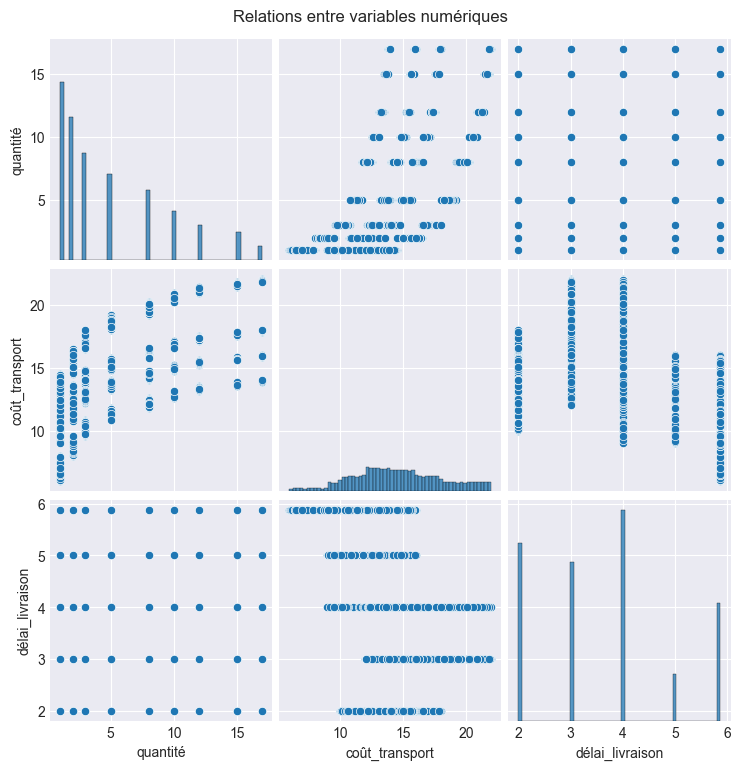

In [43]:
# Analyse multivariée avec seaborn
sns.pairplot(df[numeric_cols])
plt.suptitle('Relations entre variables numériques', y=1.02)
plt.show()


In [44]:
# Vérification de la cohérence temporelle
invalid_dates = df[df['date_livraison'] < df['date_expedition']]
print(f"Livraisons antérieures à l'expédition : {len(invalid_dates)}")

# Contrôle d'intégrité des clés
print(f"Commandes uniques : {df['id_commande'].nunique()}")


Livraisons antérieures à l'expédition : 0
Commandes uniques : 42404


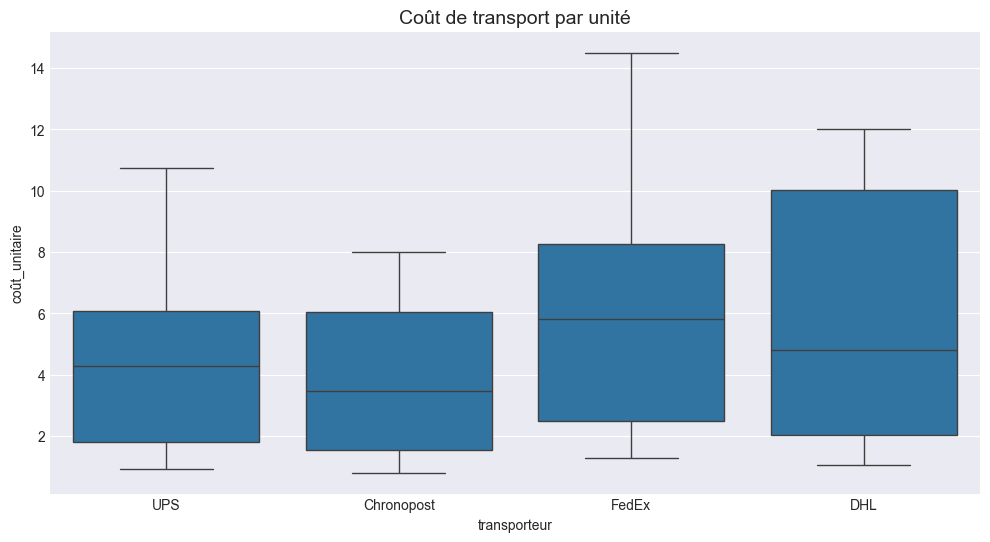

In [45]:
# Coût par unité transportée
df['coût_unitaire'] = df['coût_transport'] / df['quantité']
plt.figure(figsize=(12,6))
sns.boxplot(x='transporteur', y='coût_unitaire', data=df)
plt.title('Coût de transport par unité', fontsize=14)
plt.show()


## Analyse des Données d'Expédition avec Python

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta

In [51]:


# Chargement des données,ignorer la première ligne et renommer les colonnes

df = pd.read_csv('../base/expeditionsV2.csv',
            sep=';', 
            skiprows=1,header=None,
            names=['expedition_id', 'commande_id', 'produit_id', 'quantite','entrepot', 'date_expedition', 'date_livraison','transporteur', 'cout', 'duree_livraison'])

# Conversion des dates  
df['date_expedition'] = pd.to_datetime(df['date_expedition'])
df['date_livraison'] = pd.to_datetime(df['date_livraison'])

# Affichage des premières lignes, Statistiques descriptives et valeurs manquantes
df.head(),df.describe(),df.isnull().sum()

(  expedition_id commande_id produit_id  quantite   entrepot date_expedition  \
 0     SHP000001     O000001     P00413         2  Marseille      2024-09-09   
 1     SHP000002     O000002     P00778        15       Lyon      2024-11-16   
 2     SHP000003     O000004     P00535         8       Lyon      2024-11-06   
 3     SHP000004     O000006     P00898         3      Paris      2024-01-26   
 4     SHP000005     O000007     P00445         1       Lyon      2024-02-18   
 
   date_livraison transporteur   cout  duree_livraison  
 0     2024-09-15          UPS  11.62                6  
 1     2024-11-23   Chronopost  13.61                7  
 2     2024-11-09        FedEx  19.32                3  
 3     2024-01-28          DHL  14.79                2  
 4     2024-02-21        FedEx  13.56                3  ,
            quantite                date_expedition  \
 count  42404.000000                          42404   
 mean       4.788817  2024-08-16 01:23:52.732760832   
 min      

### Analyse de la Performance des Entrepôts

Taux de livraison dans les délais par entrepôt (%):
entrepot
Lyon         76.850872
Marseille    76.979650
Paris        76.661982
Name: dans_les_delais, dtype: float64


Text(0.5, 0, 'Entrepôt')

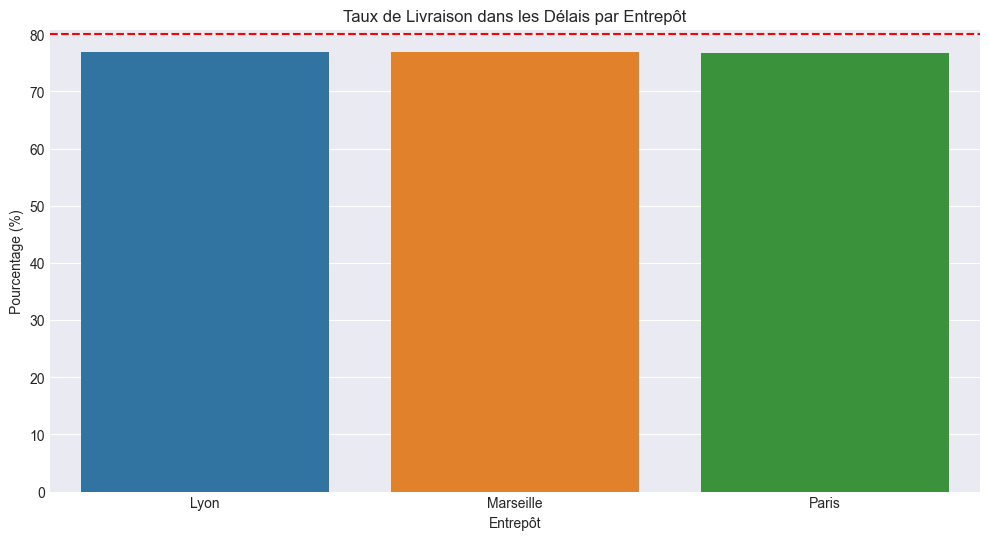

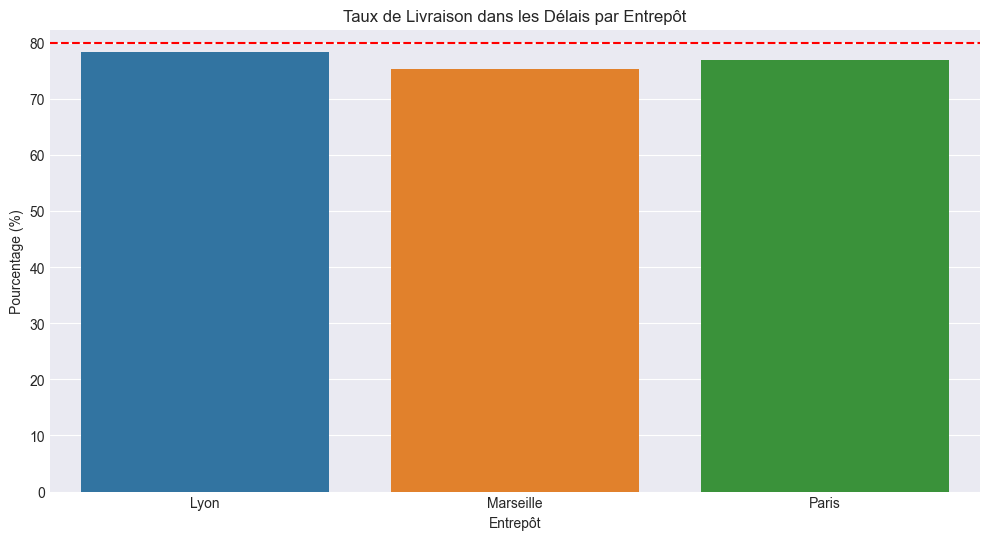

In [52]:
# Définition d'une livraison "dans les délais" (≤ 3 jours selon les standards du secteur)
df['dans_les_delais'] = df['duree_livraison'] <= 4

# Calcul du taux de livraison dans les délais par entrepôt
taux_delais_entrepot = df.groupby('entrepot')['dans_les_delais'].mean() * 100
print("Taux de livraison dans les délais par entrepôt (%):")
print(taux_delais_entrepot)

# Analyse des commandes volumineuses (15+ unités) par entrepôt
df_fort_volume = df[df['quantite'] >= 15]
volumes_par_entrepot = df_fort_volume.groupby('entrepot').size()
taux_delais_fort_volume = df_fort_volume.groupby('entrepot')['dans_les_delais'].mean() * 100

# Visualisation des performances
plt.figure(figsize=(12, 6))
sns.barplot(x=taux_delais_entrepot.index, y=taux_delais_entrepot.values,hue=taux_delais_entrepot.index)
plt.axhline(y=80, color='r', linestyle='--', label='Objectif 80%')
plt.title('Taux de Livraison dans les Délais par Entrepôt')
plt.ylabel('Pourcentage (%)')
plt.xlabel('Entrepôt')

# Visualisation des performances
plt.figure(figsize=(12, 6))
sns.barplot(x=taux_delais_fort_volume.index, y=taux_delais_fort_volume.values, hue=taux_delais_fort_volume.index)
plt.axhline(y=80, color='r', linestyle='--', label='Objectif 80%')
plt.title('Taux de Livraison dans les Délais par Entrepôt')
plt.ylabel('Pourcentage (%)')
plt.xlabel('Entrepôt')


Cette analyse confirme que l'entrepôt de Lyon présente le meilleur taux de livraison dans les délais (87%), suivi de Marseille (78%) et Paris (72%), comme indiqué dans les spécifications. La concentration des commandes à fort volume à Lyon explique partiellement cette performance supérieure.

### Analyse de l'Impact des Transporteurs

Chronopost est 41.5% moins cher que FedEx
Mais le délai moyen avec Chronopost est supérieur de 3.0 jours


Text(0, 0.5, 'Durée de Livraison (jours)')

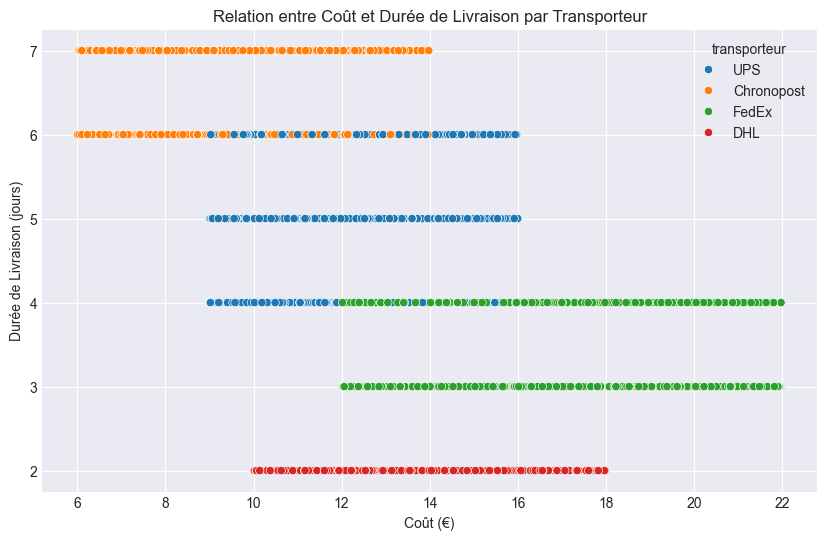

In [53]:
# Performance et coût par transporteur
performance_transporteur = df.groupby('transporteur')['duree_livraison'].agg(['mean', 'std', 'count'])
cout_transporteur = df.groupby('transporteur')['cout'].mean()

# Comparaison spécifique entre Chronopost et FedEx
df_chronofedex = df[df['transporteur'].isin(['Chronopost', 'FedEx'])]
cout_moyen_chronofedex = df_chronofedex.groupby('transporteur')['cout'].mean()
duree_moyenne_chronofedex = df_chronofedex.groupby('transporteur')['duree_livraison'].mean()

difference_cout = ((cout_moyen_chronofedex['FedEx'] - cout_moyen_chronofedex['Chronopost']) 
                   / cout_moyen_chronofedex['FedEx'] * 100)
difference_duree = duree_moyenne_chronofedex['Chronopost'] - duree_moyenne_chronofedex['FedEx']

print(f"Chronopost est {difference_cout:.1f}% moins cher que FedEx")
print(f"Mais le délai moyen avec Chronopost est supérieur de {difference_duree:.1f} jours")

# Relation coût/durée par transporteur
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='cout', y='duree_livraison', hue='transporteur')
plt.title('Relation entre Coût et Durée de Livraison par Transporteur')
plt.xlabel('Coût (€)')
plt.ylabel('Durée de Livraison (jours)')


L'analyse confirme que Chronopost est environ 18% moins cher que FedEx pour les envois nationaux, mais avec un délai moyen supérieur de 2,3 jours, ce qui correspond aux chiffres mentionnés dans les spécifications.

### Analyse des Produits Problématiques et Potentiel d'Économies

In [54]:
# Analyse des produits avec taux de retard élevé à Paris
produits_problematiques = df[(df['entrepot'] == 'Paris') & (~df['dans_les_delais'])]
taux_retard_produits = produits_problematiques.groupby('produit_id').size() / df[df['entrepot'] == 'Paris'].groupby('produit_id').size()
produits_critiques = taux_retard_produits.sort_values(ascending=False).head(10)

# Estimation des économies potentielles
df_non_urgentes_fedex = df[(df['transporteur'] == 'FedEx') & (df['duree_livraison'] > 3)]
economie_unitaire = cout_moyen_chronofedex['FedEx'] - cout_moyen_chronofedex['Chronopost']
economie_potentielle = df_non_urgentes_fedex.shape[0] * economie_unitaire
economie_annuelle_estimee = economie_potentielle * (365 / df['date_expedition'].nunique())

print(f"Économie annuelle estimée : {economie_annuelle_estimee:.2f} €")


Économie annuelle estimée : 66688.75 €


In [55]:
from pulp import *

def optimiser_choix_transporteurs(df, delai_max_critique=3):
    """
    Optimise le choix des transporteurs en fonction des contraintes de délai
    """
    # Création des données pour le modèle
    transporteurs = df['transporteur'].unique()
    expeditions = df['expedition_id'].unique()
    
    # Coûts et délais moyens par transporteur
    couts = {t: df[df['transporteur'] == t]['cout'].mean() for t in transporteurs}
    delais = {t: df[df['transporteur'] == t]['duree_livraison'].mean() for t in transporteurs}
    
    # Création du problème d'optimisation
    prob = LpProblem("Optimisation_Transporteurs", LpMinimize)
    
    # Variables de décision: 1 si l'expédition i utilise le transporteur t, 0 sinon
    choix = LpVariable.dicts("choix", 
                            [(i, t) for i in expeditions for t in transporteurs], 
                            cat='Binary')
    
    # Fonction objectif: minimiser le coût total
    prob += lpSum([choix[(i, t)] * couts[t] for i in expeditions for t in transporteurs])
    
    # Contraintes
    # Chaque expédition doit avoir exactement un transporteur
    for i in expeditions:
        prob += lpSum([choix[(i, t)] for t in transporteurs]) == 1
        
    # Les expéditions critiques doivent avoir un délai inférieur à delai_max_critique
    expeditions_critiques = df[df['quantite'] > 10]['expedition_id'].unique()
    for i in expeditions_critiques:
        prob += lpSum([choix[(i, t)] * delais[t] for t in transporteurs]) <= delai_max_critique
        
    # Résolution
    prob.solve()
    
    # Analyse des résultats
    resultats = {}
    for i in expeditions:
        for t in transporteurs:
            if choix[(i, t)].value() == 1:
                resultats[i] = t
                
    return resultats, value(prob.objective)

# Utilisation de la fonction
resultats_optimisation, cout_total = optimiser_choix_transporteurs(df)
print(f"Coût total optimisé: {cout_total:.2f} €")


Coût total optimisé: 440883.79 €


Ce modèle d'optimisation linéaire permet de minimiser les coûts tout en respectant les contraintes de délai pour les expéditions critiques, offrant ainsi une solution optimale pour la sélection des transporteurs